In [1]:
from project import Projection
from Problem import Problem
from main_dynamic import run_experiment, load_config
from Phase1 import solve_CQ_feasible
from Phase2_1_obj import optim_Universal
from utils import visualize_pareto_front

In [2]:
import autograd.numpy as np
from autograd import jacobian
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
import pandas as pd
import math

# Prob

In [3]:
def f(x):
    return np.array([
        4*x[0]**2 + 4*x[1]**2,
        (x[0] - 5)**2 + (x[1] - 5)**2
    ])


#--------------- C --------------------#
def c1(x):
    return -(x[0] - 5)**2 - x[1]**2 + 25
def c2(x):
    return -(x[0] - 8)**2 - (x[1] + 3)**2 + 17.7


#--------------- Q --------------------#
def q1(y):
    return 50**2 - (y[0] - 50)**2 - (y[1] - 50)**2

def q_plus(y):
    center = 50.0
    radius_sq = 50**2  
    
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

# Hàm dùng cho Projection 
cons_C = (
    {
        'type': 'ineq', 'fun' : c1,     
    },
    {
        'type': 'ineq', 'fun' : c2,     
    }
)

dim_x = 2
bounds_x = Bounds([-15,-15],[30, 30])

cons_Q = (
    {
        'type': 'ineq', 'fun' : q1,     
    },    
)

cons_Qplus = (
    {'type': 'ineq', 'fun': q_plus},
)
dim_y = 2

In [4]:
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

# Setup Problem
prob = Problem(
    f=[f], jac_f=[jacobian(f)], C=[], Q=[], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

In [5]:
x_init = np.array([-10., -10.])

# Config

In [6]:
from ruamel.yaml import YAML
from ruamel.yaml.comments import CommentedSeq

def update_config(file_path, x_init_np):
    yaml = YAML()
    yaml.preserve_quotes = True
    yaml.indent(mapping=2, sequence=4, offset=2)

    with open(file_path, 'r', encoding='utf-8') as f_in:
        config = yaml.load(f_in)

    val_list = x_init_np.tolist() if hasattr(x_init_np, 'tolist') else x_init_np
    
    flow_list = CommentedSeq(val_list)
    flow_list.fa.set_flow_style() 

    config['initialization']['x_init'] = flow_list
    
    config['phase1']['gamma'] = 0.00055
    config['phase1']['max_iter'] = 300
    
    config['phase2']['mu'] = 1
    config['phase2']['init_params'] = 1
    config['phase2']['expo_alpha'] = 0.25
    config['phase2']['expo_lambda'] = 0.75
    config['phase2']['max_iter'] = 500

    # 3. Ghi lại vào file
    with open(file_path, 'w', encoding='utf-8') as f_in:
        yaml.dump(config, f_in)
    
    print(f"✅ Đã cập nhật xong file: {file_path}")

# --- CHẠY THỬ ---
config_file = 'config.yaml'
update_config(config_file, x_init)

with open(config_file, 'r', encoding='utf-8') as f_in:
    print("\nNội dung file sau khi sửa:")
    print(f_in.read())

✅ Đã cập nhật xong file: config.yaml

Nội dung file sau khi sửa:
data:
  test_ray:
    -   - 1.0
        - 0.0
    -   - 0.9965844930066698
        - 0.08257934547233232
    -   - 0.9863613034027223
        - 0.1645945902807339
    -   - 0.9694002659393304
        - 0.24548548714079912
    -   - 0.9458172417006346
        - 0.32469946920468346
    -   - 0.9157733266550574
        - 0.4016954246529694
    -   - 0.8794737512064891
        - 0.4759473930370735
    -   - 0.8371664782625285
        - 0.5469481581224268
    -   - 0.7891405093963936
        - 0.6142127126896678
    -   - 0.7357239106731316
        - 0.677281571625741
    -   - 0.6772815716257411
        - 0.7357239106731316
    -   - 0.6142127126896678
        - 0.7891405093963936
    -   - 0.5469481581224269
        - 0.8371664782625285
    -   - 0.4759473930370736
        - 0.8794737512064891
    -   - 0.40169542465296953
        - 0.9157733266550574
    -   - 0.32469946920468357
        - 0.9458172417006346
    -   - 0.245

# Solve

In [7]:
results = run_experiment(prob)

=== BẮT ĐẦU PHASE 1: TÌM ĐIỂM KHẢ THI ===
Khởi tạo: x0: [-10. -10.]
Chiếu lên C được: x: [ 4.0789 -4.5249]


100%|██████████| 300/300 [00:01<00:00, 172.34it/s]


+-----+------------------------+---------+--------------------------+------------------------+----------+-----------+
|  k  | x_new                  | gamma_k | y                        | z_proj                 |   e_x    |    e_f    |
+-----+------------------------+---------+--------------------------+------------------------+----------+-----------+
|  0  | [ 4.078929, -4.524861] | 0.0006  | [148.448122,  91.571354] | [96.061746, 69.450335] | 1.337431 | 56.865384 |
|  10 | [ 3.795912, -3.16014 ] | 0.0000  | [97.581734, 68.037713]   | [96.753307, 67.723665] | 0.001349 |  0.885956 |
|  20 | [ 3.795597, -3.151655] | 0.0000  | [97.357944, 67.900057]   | [96.770575, 67.678047] | 0.000482 |  0.627926 |
|  30 | [ 3.795462, -3.147864] | 0.0000  | [97.258323, 67.838594]   | [96.778364, 67.657424] | 0.000285 |  0.513013 |
|  40 | [ 3.795383, -3.145583] | 0.0000  | [97.198485, 67.80162 ]   | [96.783074, 67.644942] | 0.000177 |  0.443975 |
|  50 | [ 3.79533 , -3.144039] | 0.0000  | [97.15804 , 6

In [8]:
pf_cloud = np.load("test/ex4/target_space.npy")
pf_targets = np.load("test/ex4/pf_true.npy")

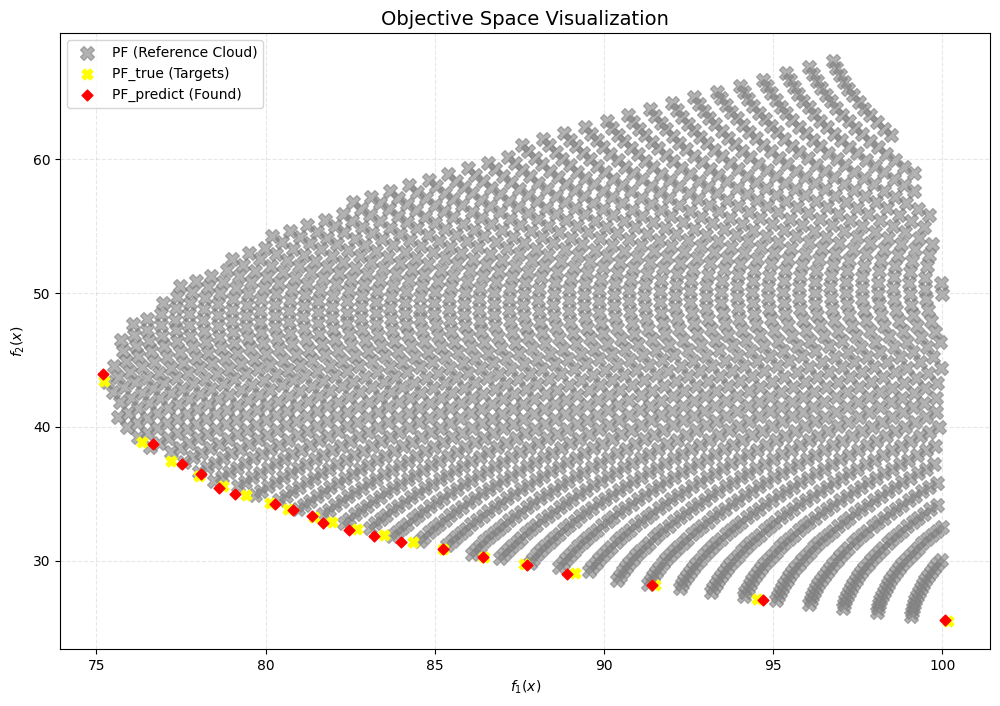

In [9]:
visualize_pareto_front(
    pf_pred=results["pareto_f"], 
    pf_cloud=pf_cloud,   
    pf_targets=pf_targets,
    title="Objective Space Visualization",
    figsize=(12, 8)
)

In [19]:
np.save("test/ex4/pf_dynamic_true.npy", results["pareto_f"])